In [101]:
using ProfileView
using Knet, AutoGrad
using Knet: sigm_dot, tanh_dot

Options

In [102]:
datafiles    = ["input.txt"]  # If provided, use first file for training, second for dev, others for test.
togenerate   = 500            # If non-zero generate given number of characters.
epochs       = 20            # Number of epochs for training.
hidden       = [128]          # Sizes of one or more LSTM layers.
embed        = 168            # Size of the embedding vector.
batchsize    = 128            # Number of sequences to train on in parallel
seqlength    = 20             # Maximum number of steps to unroll the network for bptt. Initial epochs will use the epoch number as bptt length for faster convergence.
seed         = -1             # Random number seed. -1 or 0 is no fixed seed
lr           = 1e-1           # Initial learning rate
gclip        = 3.0            # Value to clip the gradient norm at.
dpout        = 0.0            # Dropout probability.

0.0

In [103]:
seed > 0 && srand(seed)

# read text and report lengths
text = map(readstring, datafiles)
!isempty(text) && info("Chars read: $(map((f,c)->(basename(f),length(c)),datafiles,text))")

INFO: Chars read: Tuple{String,Int64}[("input.txt", 105989)]


# Task-1: Create dictionary by completing createVocabulary function
function createVocabulary takes text::Array{Any,1} that contains the names of datafiles you provided by opts[:datafiles] argument. It returns vocabulary::Dict{Char,Int}() for given text. In this lab, your text array is length of 1. For example the text is ["content of input"]. Note that for the sake of simplicity, we do NOT use validation or test dataset in this lab. You can try it by splitting your data into 3 different set after the lab.

In [104]:
function createVocabulary(text)
    vocab = Dict{Char,Int}()
    # MY CODE STARTS HERE 
    
    for (char_i,unique_character) in enumerate(unique(text[1]))
        vocab[Char(unique_character)] = char_i
    end
    # MY CODE ENDS HERE
    return vocab
end



createVocabulary (generic function with 1 method)

In [105]:
vocab = createVocabulary(text)
info("$(length(vocab)) unique chars.") # The output should be 75 unique chars for input.txt

INFO: 75 unique chars.


# LSTM Network function

In a regular RNN - The core idea is to use past hidden weights, present input to calculate the next set of hidden state weights. i.e st = (Ux/t + W/st-1) . 

LSTM equations looks scary and there are a lot of them forget gate, ingate , output gate and change . But it's basically just another way to calculate the hidden states (except in this scenario the vanishing gradients is not an issue). 

In a LSTM network you have initialize four sets of weights Wf (Forget gate ft) Wi - input gage, Wo - Output, Wc - Change gate weights and the corresponding biases. So instead of creating new variables looks like this cell code is just creating one giant weights/gates and then split it into parts of equal width(columnwise)

In [145]:
function lstm(weight,bias,hidden,cell,input)
    hsize   = size(hidden,2)
    zt  = sigm_dot(hcat(input,hidden) *weight[:,1:hsize] .+ bias[:,1:hsize])
    rt  = sigm_dot(hcat(input,hidden) *weight[:,1+hsize:2hsize] .+ bias[:,1+hsize:2hsize])
    change  = tanh_dot(hcat(input,rt.*hidden) *weight[:,1+2hsize:3hsize] .+ bias[:,1+2hsize:3hsize])
    hidden  = zt .* hidden + (1-zt).*change
    return (hidden,cell)
end

lstm (generic function with 1 method)

# Task-2: Create Initial weights
initweights creates the weights and biases for the model. We are using LSTM network. We provide init function(for weights) and bias function(for bias)

First we have to initialize weights from the placeholder here x=embed and embed being 168 looks like the input vector is 168 
long vector. The first part of this model is the relationshp betwen concatted inputs and hidden weights .This belongs to the embedding layer. Also for multiple hidden layers, y1=cell(x) , y2= cell(y1).  

In [142]:
function initweights(hidden, vocab, embed)
    init(d...) = xavier(d...)
    bias(d...) = zeros(d...)
    model = Vector{Any}(2*length(hidden)+3)
    X = embed
    for k = 1:length(hidden)
        # MY CODE STARTS HERE
        #Concatted input and hidden layer weights
        num_nodes_hidden = hidden[k]
        model[2k-1]=init(X+num_nodes_hidden,4*num_nodes_hidden) #Because we have to initialize 4w's - wf,wi,wo,wc
        model[2k]=bias(1,4*num_nodes_hidden)
        X = num_nodes_hidden
        # MY CODE ENDS HERE
    end
    model[end-2] = init(vocab,embed)
    model[end-1] = init(hidden[end],vocab)
    model[end] = bias(1,vocab)
    return model
end

initweights (generic function with 1 method)

# Task-3: Create Initial state
At each time step, we take the hidden state from previous time step as input. To be able to do that,first we need to initialize hidden state. We also store updated hidden states in array created here. We initialize state as a zero matrix.

In [126]:
let blank = nothing; global initstate
    function initstate(model, batch)
        nlayers = div(length(model)-3,2)
        state = Vector{Any}(2*nlayers)
        for k = 1:nlayers
            bias = model[2k]
            hidden = div(length(bias),4)
            if typeof(blank)!=typeof(bias) || size(blank)!=(batch,hidden)
                blank = fill!(similar(bias, batch, hidden),0)
            end
            state[2k-1] = state[2k] = blank
        end
        return state
    end
end

initstate (generic function with 1 method)

# Task-4: Create Predict function
predict is a function that takes w(model) created in initweights, s(state) created in initstate and input whose size is batchsize vocabulary You need to implement predict function for LSTM. You must use lstm function here. LSTM function is provided above.

In [127]:
function predict(model, state, input; pdrop=0)
    nlayers = div(length(model)-3,2)
    newstate = similar(state)
    for k = 1:nlayers
        # MY CODE STARTS HERE
        #newstate[2k-1] is the hidden layer (look at the initweights for more explanation)
        input = dropout(input, pdrop)
        (newstate[2k-1],newstate[2k])=lstm(model[2k-1],model[2k],state[2k-1],state[2k],input)
        input = newstate[2k-1]
        # MY CODE ENDS HERE
    end
    return input,newstate
end

predict (generic function with 1 method)

# Generate and Sample function
Generate function is a function we use to create some text that is similar to our training data. We provide sample function to you. You can predict the next character by using sample function once you calculate the probabilities given the input. index to char is the same dictionary as you created with createdictionary function but it works in the reverse direction. It gives you the character given the index.

In [128]:
function generate(model, tok2int, nchar)
    int2tok = Vector{Char}(length(tok2int))
    for (k,v) in tok2int; int2tok[v] = k; end
    input = tok2int[' ']
    state = initstate(model, 1)
    for t in 1:nchar
        embed = model[end-2][[input],:]
        ypred,state = predict(model,state,embed)
        ypred = ypred * model[end-1] .+ model[end]
        input = sample(exp.(logp(ypred)))
        print(int2tok[input])
    end
    println()
end

function sample(p)
    p = convert(Array,p)
    r = rand()
    for c = 1:length(p)
        r -= p[c]
        r < 0 && return c
    end
end

sample (generic function with 1 method)

# Now, Let's generate some random sample

In [146]:
model = initweights(hidden, length(vocab), embed)
state = initstate(model,1)

println("########## RANDOM MODEL OUTPUT ############")
generate(model, vocab, togenerate) ## change togenerate if you want longer sample text

########## RANDOM MODEL OUTPUT ############
Qzr-5lBvsWG;\!q*VVHIi9\jUBWB:
g8oTd2K7g9'u}nFu3RK:.-*GS*4DrHrxWo{
\'8Vdi.HlPt?0ez&*w2MdF7}Bt6HxCNdWWV2I&0SW\uV.*\J.m\0CUz7LLz6yJqpSOlYrhmNF?MvrNjoSex
2-
6V*8Wsq::;Blkgo0\B
cKJ ,?oPDK1WskNTWetI'9VPR1Ypr.*GFDaoE}Bt\
m8k;RD0 tRKAT!mty6'bfEUmfVRHl3VFBGQLHQKgg*x7Fb1'G
AMl6By-  s:6dK-lrn !IQqa:5BFoSuMTJsOV2U:{M
*unD,VlkED:Lyf8uA3pJwaUW
pzP'5k?;phl?GJM5lciT!?:;Y01wPk58M,
WTmb3VChBYjme\Fi8k7'1u-&,1z0KRnxlu82jm&NnEcGFJbTm'-w72QCkt!MCTQzc.'SwJFzmIkNc.9z1,cRj2FL?,9IGKh,p?RVabTJcvpBpkC Itg-N8rU5! jF{CqTRrDU


We provide minibatch function for you. You do not have to do it for this lab. But we suggest you to understand the idea since you need to do it in your own project and future labs

In [100]:
function minibatch(chars, tok2int, batch_size)
    chars = collect(chars)
    nbatch = div(length(chars), batch_size)
    data = [zeros(Int,batch_size) for i=1:nbatch ]
    for n = 1:nbatch
        for b = 1:batch_size
            char = chars[(b-1)*nbatch + n]
            data[n][b] = tok2int[char]
        end
    end
    return data
end

minibatch (generic function with 1 method)

# Task-5: Create loss function

In [83]:
function loss(model, state, sequence, range=1:length(sequence)-1; newstate=nothing, pdrop=0)
    preds = []
    for t in range
        input = model[end-2][sequence[t],:]
        pred,state = predict(model,state,input; pdrop=pdrop)
        push!(preds,pred)
    end
    if newstate != nothing
        copy!(newstate, map(AutoGrad.getval,state))
    end
    pred0 = vcat(preds...)
    pred1 = dropout(pred0,pdrop)
    pred2 = pred1 * model[end-1]
    pred3 = pred2 .+ model[end]
    logp1 = logp(pred3,2)
    nrows,ncols = size(pred3)
    golds = vcat(sequence[range[1]+1:range[end]+1]...)
    index = similar(golds)
    @inbounds for i=1:length(golds)
        index[i] = i + (golds[i]-1)*nrows
    end
    logp2 = logp1[index]
    logp3 = sum(logp2)
    return -logp3 / length(golds)
end

# Knet magic
lossgradient = grad(loss)

function avgloss(model, sequence, S)
    T = length(sequence)
    B = length(sequence[1])
    state = initstate(model, B)
    total = count = 0
    for i in 1:S:T-1
        j = min(i+S-1,T-1)
        n = j-i+1
        total += n * loss(model, state, sequence, i:j; newstate=state)
        count += n
    end
    return total / count
end

avgloss (generic function with 1 method)

# Task-6: Create Train function¶
Implement bptt(Backpropagation through time) function for training. You need to fill up only 3 lines(or even small numbers). You need use lossgradient function and update! function.

In [84]:
function train(model, sequence, optim, S; pdrop=0)
    T = length(sequence)
    B = length(sequence[1])
    state = initstate(model, B)
    for i in 1:S:T-1
        # MY CODE STARTS HERE
        end_seq = 1+S-1
        if end_seq > T-1
            end_seq = T-1
        end
        gradient_loss = lossgradient(model,state,sequence,1:end_seq,newstate=state,pdrop=pdrop)
        update!(model,gradient_loss,optim)
        # MY CODE ENDS HERE
    end
end

train (generic function with 1 method)

# Now we are ready. First let's see the initial loss¶

In [85]:
data =  map(t->minibatch(t, vocab, batchsize), text)
# Print the loss of randomly initialized model.
losses = map(d->avgloss(model,d,100), data)
println((:epoch,0,:loss,losses...))

(:epoch, 0, :loss, 4.315800185928183)


# Below is the training part of RNN(with Adam)¶

In [86]:
optim = map(x->Adam(lr=lr, gclip=gclip), model)
# MAIN LOOP
for epoch=1:epochs
    @time @profile train(model, data[1], optim, min(epoch,seqlength); pdrop=dpout)
    # Calculate and print the losses after each epoch
    losses = map(d->avgloss(model,d,100),data)
    println((:epoch,epoch,:loss,losses...))
end

 16.006818 seconds (2.71 M allocations: 15.744 GiB, 12.92% gc time)
(:epoch, 1, :loss, 10.595825772305442)
 15.765277 seconds (2.19 M allocations: 13.392 GiB, 11.21% gc time)
(:epoch, 2, :loss, 31.253892272445714)
 14.869835 seconds (2.02 M allocations: 12.604 GiB, 15.24% gc time)
(:epoch, 3, :loss, 30.919238093118658)
 20.030816 seconds (1.95 M allocations: 12.210 GiB, 31.84% gc time)
(:epoch, 4, :loss, 27.517133258838925)
 26.709552 seconds (1.97 M allocations: 12.003 GiB, 39.61% gc time)
(:epoch, 5, :loss, 25.84323166594993)
 26.608144 seconds (1.98 M allocations: 11.817 GiB, 49.58% gc time)
(:epoch, 6, :loss, 24.28690535967556)
 22.559359 seconds (2.00 M allocations: 11.776 GiB, 47.35% gc time)
(:epoch, 7, :loss, 22.16908169082633)
 21.315343 seconds (2.00 M allocations: 11.677 GiB, 44.64% gc time)
(:epoch, 8, :loss, 19.593651875892267)
 20.354713 seconds (2.00 M allocations: 11.556 GiB, 42.06% gc time)
(:epoch, 9, :loss, 17.84337811904759)
 21.020957 seconds (2.00 M allocations: 1

# If you have checked the loss decreasing, let's create some text with our model

In [87]:
println("########## FINAL  MODEL OUTPUT ############")
state = initstate(model,1)
generate(model, vocab, togenerate)

########## FINAL  MODEL OUTPUT ############
the fthe pe depedl ldddddddddddedddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd


before your program finished. To profile for longer runs, call Profile.init
with a larger buffer and/or larger delay.


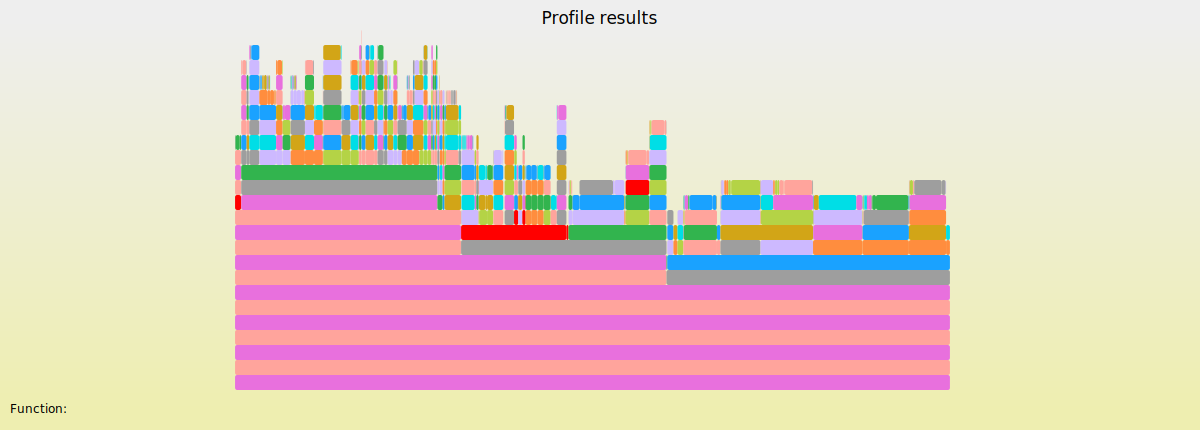

In [88]:
ProfileView.view()